# Кластеризация спам-текстов.

Цель: с помощью алгоритма KMeans провести кластеризацию текстов СМС-сообщений и выявить в спамных СМС слова с наибольшей частотой встречаемости.

Задачи:

1. Провести подготовку текста.

2. Подобрать оптимальное количество кластеров, провести кластеризацию с помощью алгоритма KMeans.

3. Оценить качество кластеризации с помощью метрик silhouette_score и v_measure_score.

4. Оценить частоту встречаемости слов в спамных СМС и выявить наиболее частые слова.

Импортируем библиотеки.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
from nltk.stem import SnowballStemmer
import nltk
#nltk.download('stopwords') 
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score
from sklearn.utils import parallel_backend
from tqdm import notebook
import matplotlib.pyplot as plt
import wordcloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Считываем набор данных. Используем кодировку latin-1.

In [2]:
df = pd.read_csv(r'C:/Users/Alex/Desktop/spam.csv', encoding='latin-1')

Смотрим на набор данных.

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Удаляем поля, содержащие нулевые значения.

Также сделаем биннинг целевой переменной: 1, если сообщение спамное, и 0, если не спамное.

In [4]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.rename(columns = {'v2' : 'text', 'v1' : 'target'}, inplace=True)

In [5]:
df['target'] = df['target'].apply(lambda x: 1 if x == 'spam' else 0)

Проверяем.

In [6]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Всё правильно. 

Подготовим текст к кластеризации.

Сначала проведём стемминг текста (лемматизация для англоязычных текстов, как правило, не используется), затем - с помощью регулярных выражений - избавимся от знаков препинания и других лишних синтаксических конструкций (оставим только ', так как в английском языке она смыслообразующая). Полученный текст приведём к unicode-формату, чтобы с текстом можно было работать векторизаторами.

In [7]:
english_stemmer = SnowballStemmer('english')
with parallel_backend('threading'):
    df['text_clear'] = df['text'].apply(lambda x: ' '.join(re.sub(r'[^a-z \']', ' ', 
                                                              english_stemmer.stem(x)).split())).astype('U')
    df.drop('text', axis=1, inplace=True)

Создадим экземпляр векторизатора. Данный векторизатор также известен как "мешок слов". Он посмотрит на весь набор данных, создаст список из уникальных слов в тексте и создаст массив, где признаки - это уникальные слов из текста, а объекты - 1 или 0 в зависимости от того, есть ли в данном предложении это слово.

Далее трансформируем массив в DataFrame.

In [8]:
cv = CountVectorizer(stop_words=list(stopwords.words('english')))
text = pd.DataFrame(data=cv.fit_transform(df['text_clear']).toarray(), columns=cv.get_feature_names())

Переберём количество кластеров от 2 до 20 и попытаемся понять, какое их количество оптимально в данном случае. Для тестирования качества кластеризации используем метрики silhouette_score и v_measure_score.

In [9]:
silhouette = []
v_measure = []
for i in notebook.tqdm(range(2, 21)):
    model = KMeans(n_clusters=i, random_state=42)
    with parallel_backend('threading'):
        clusters = model.fit_predict(text)
        silhouette.append(silhouette_score(text, clusters))
        v_measure.append(v_measure_score(df['target'], clusters))

Визуализируем результаты.

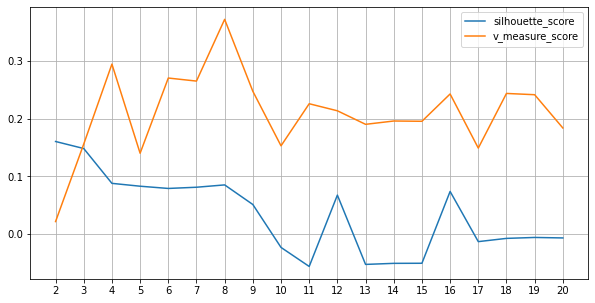

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(silhouette, label='silhouette_score')
plt.plot(v_measure, label='v_measure_score')
plt.legend()
plt.grid()
plt.xticks(ticks=range(19), labels=[i for i in range(2, 21)]);

Лучшего качества кластеризации - согласно метрике v_measure_score - удалось добиться на 8 кластерах. Примем это значение кластеров за оптимальное.

Вернёмся к исходному DataFrame. Присоединим к нему номера кластеров, предсказанные алгоритмом KMeans.

In [11]:
clusters = KMeans(n_clusters=8, random_state=42).fit_predict(text)
df = df.join(pd.Series(clusters, index=df.index, name='cluster'))

Проверяем.

In [12]:
df.head()

,target,text_clear,cluster
0,0,go until jurong point crazy available only in ...,2
1,0,ok lar joking wif u oni,2
2,1,free entry in a wkly comp to win fa cup final ...,4
3,0,u dun say so early hor u c already then say,2
4,0,nah i don't think he goes to usf he lives arou...,2


Посмотрим, в каких из 8 кластеров наиболее высокая концентрация спамных СМС.

In [13]:
for i in set(df['cluster']):
    print('В кластер № {} попало {} спамных сообщений ({:.2f} % от общего числа спамных сообщений)'.format(i, 
    len(df[(df['cluster'] == i) & (df['target'] == 1)]), 
    (len(df[(df['cluster'] == i) & (df['target'] == 1)]) / len(df[df['target'] == 1]) * 100)))

В кластер № 0 попало 0 спамных сообщений (0.00 % от общего числа спамных сообщений)
В кластер № 1 попало 288 спамных сообщений (38.55 % от общего числа спамных сообщений)
В кластер № 2 попало 162 спамных сообщений (21.69 % от общего числа спамных сообщений)
В кластер № 3 попало 0 спамных сообщений (0.00 % от общего числа спамных сообщений)
В кластер № 4 попало 241 спамных сообщений (32.26 % от общего числа спамных сообщений)
В кластер № 5 попало 0 спамных сообщений (0.00 % от общего числа спамных сообщений)
В кластер № 6 попало 0 спамных сообщений (0.00 % от общего числа спамных сообщений)
В кластер № 7 попало 56 спамных сообщений (7.50 % от общего числа спамных сообщений)


Видим, что все спамные СМС сосредоточены в 1, 2, 4 и 7 кластерах.

Попробуем красuво визуализировать частоту встречаемости слов в спамных СМС с помощью wordcloud (или облака слов).

Напишем функцию, которая будет принимать на вход список слов из спамных СМС в каждом из кластеров и отрисовывать облако слов. В облаке слов визуализируются все слова, которые функция получила на вход, при этом чем больше размер слова, тем чаще оно встречается в тексте.

In [14]:
def show_wordcloud(words, title):
    
    string = ''
    for i in words:
        string += i + ' '
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=set(stopwords.words('english')),background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(string)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

Функция написана. Теперь переберём в цикле номера кластеров и визуализируем частоту встречаемости слов с помощью облака слов.

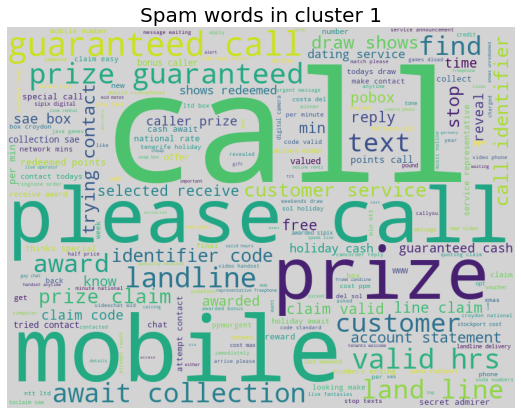

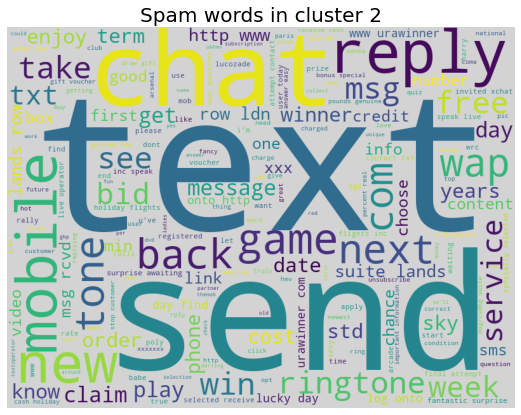

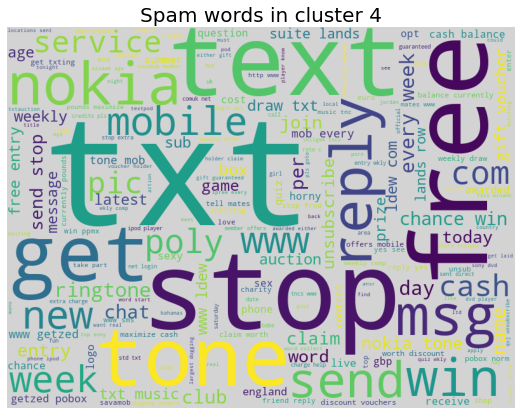

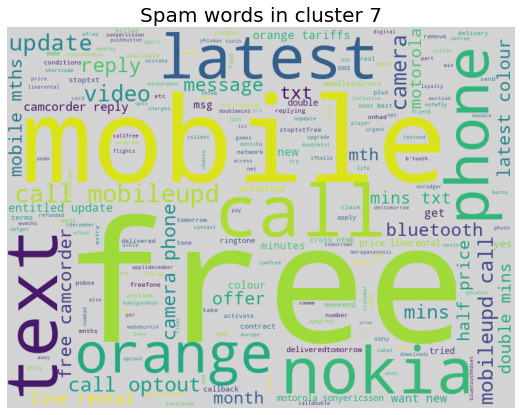

In [15]:
with parallel_backend('threading'):
    for i in notebook.tqdm([1, 2, 4, 7]):
        text = df[(df['cluster'] == i) & (df['target'] == 1)]['text_clear']
        words = [i for i in ''.join(text).split(' ') if len(i) > 2]
        show_wordcloud(words, 'Spam words in cluster ' + str(i))  

Видим, что некоторые слова пересекаются во всех кластерах.

Интерес представляют те слова, которые есть в каждом из четырёх кластеров.

Визуализируем такие слова.

Для начала создадим 4 серии со словами, сортируя СМС по признаку спамности и номеру кластера.

In [16]:
text_1 = df[(df['cluster'] == 1) & (df['target'] == 1)]['text_clear']
text_2 = df[(df['cluster'] == 2) & (df['target'] == 1)]['text_clear']
text_3 = df[(df['cluster'] == 4) & (df['target'] == 1)]['text_clear']
text_4 = df[(df['cluster'] == 7) & (df['target'] == 1)]['text_clear']

Далее соберём слова в список. Зададим условие, что слово должно быть длиннее 2 символов, чтобы отсечь ненужные конструкции.

In [17]:
text_1 = [i for i in ''.join(df[(df['cluster'] == 1) & (df['target'] == 1)]['text_clear']).split(' ') if len(i) > 2]
text_2 = [i for i in ''.join(df[(df['cluster'] == 2) & (df['target'] == 1)]['text_clear']).split(' ') if len(i) > 2]
text_3 = [i for i in ''.join(df[(df['cluster'] == 4) & (df['target'] == 1)]['text_clear']).split(' ') if len(i) > 2]
text_4 = [i for i in ''.join(df[(df['cluster'] == 7) & (df['target'] == 1)]['text_clear']).split(' ') if len(i) > 2]

В кластере 1 у нас наибольшая концентрация спамных СМС. Переберём в цикле каждое слово из кластера 1 и проверим, входит ли оно в списки слов из других кластеров. 

В список common_words попадают только те слова, которые присутствуют во всех 4 кластерах.

In [18]:
common_words = []
for i in notebook.tqdm(text_1):
    if i in text_2 and i in text_3 and i in text_4:
        common_words.append(i)

Теперь соберём все СМС из DataFrame в список и оставим там только те, которые есть в нашем списке пересекающихся слов. Это нужно для оценки частоты встречаемости таких слов не в пределах кластера, а в рамках всего набора данных. Также нам неинтересны стоп-слова, сразу избавимся от них.

In [19]:
all_text = [i for i in ''.join(df[df['target'] == 1]['text_clear']).split(' ') if i in common_words \
            and i not in set(stopwords.words('english'))]

Из полученного списка сделаем Series и применим к нему value_counts, чтобы получить количественную характеристику частоты встречаемости каждого слова.

In [20]:
pd.options.display.max_rows = 999
pd.Series(all_text).value_counts()

free          182
txt           167
mobile        127
text          119
stop          111
claim         110
reply         101
www            98
get            77
send           67
new            63
win            63
week           53
tone           52
msg            49
phone          46
per            44
please         44
customer       43
pobox          42
find           33
video          31
message        31
number         30
ringtone       29
chance         27
offer          26
orange         25
network        24
collect        22
want           21
sms            20
apply          20
poly           20
texts          19
games          19
calls          18
opt            17
c's            17
messages       13
news           10
terms           9
give            7
month           7
visit           7
try             7
access          6
polyphonic      5
dtype: int64

Ну и напоследок визуализируем эти слова с помощью облака слов.

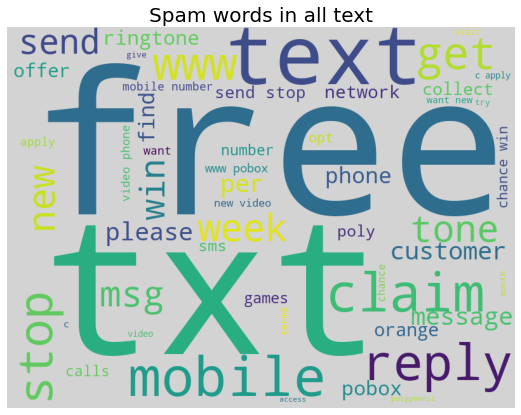

In [21]:
show_wordcloud(all_text, 'Spam words in all text')

Таким образом, мы видим, что спамное СМС наверняка будет содержать такие слова, как free, mobile, get, text, reply, www, com, txt и т.д. Главное - не отправлять СМС с кодом на короткий номер.

# Вывод.

Целью работы было проведение кластеризации текстов СМС-сообщений с помощью алгоритма KMeans и выявление в спамных СМС слов с наибольшей частотой встречаемости.

Для достижения цели были поставлены следующие задачи:

1. Провести подготовку текста.

2. Подобрать оптимальное количество кластеров, провести кластеризацию с помощью алгоритма KMeans.

3. Оценить качество кластеризации с помощью метрик silhouette_score и v_measure_score.

4. Оценить частоту встречаемости слов в спамных СМС и выявить наиболее частые слова.

В рамках работы была проведена кластеризация с помощью KMeans от 2 до 20 кластеров, качество кластеризации было оценено с помощью метрик silhouette_score и v_measure_score. Оптимальным с точки зрения метрики v_measure_score (значение метрики 0.38) является кластеризация на 8 кластеров. 

Далее была оценена концентрация спамных СМС в каждом из 8 кластеров, в результате было определено, что все спамные СМС сосредоточились в 1, 2, 4 и 7 кластерах.

Далее с помощью облака слов были визуализированы слова из СМС в каждом из кластеров.

После были определены слова, которые есть в спамных СМС в каждом кластере, частота этих слов (за исключением стоп-слов) с помощью облака слов и метода values_count была определена на всём наборе данных.

Наиболее часто встречаемыми словами в спамных СМС оказались такие слова, как free, mobile, get, text, reply, www, com, txt и т.д.

Цель и задачи работы кажутся достигнутыми. 

Из зон роста отмечу более глубокую обработку данных, эксперименты с важностью слов (TFDIF), векторизацию слов с помощью N-грамм.